In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.io import loadmat
from scipy.signal import butter, lfilter
from scipy.fftpack import fft, ifft

import stfft
import general
import eegFilter

from tqdm import tqdm

In [97]:
filename = "0903-1-5-rawdata.mat"
datadir = "../../Data/"
resultdir = "../../Result/"
data = loadmat(os.path.join(datadir, "compact"+filename))
channels = data["channels"]
cue_onset = data["cue_onset"][0,:]
times = data["times"][0,:]

fs = 2000

In [98]:
chidx = 106
roi = (-2,5)
rho = 2
ch_split = general.split_datawithmarker(channels[chidx,:], cue_onset, roi, fs)

pxx,tspec = stfft.stfft(ch_split, 200, 150, fs, rho=rho)
tfdata = np.mean(pxx, 0)
shifted = tfdata-np.reshape(np.min(tfdata,1),(1000,1))

/usr/local/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


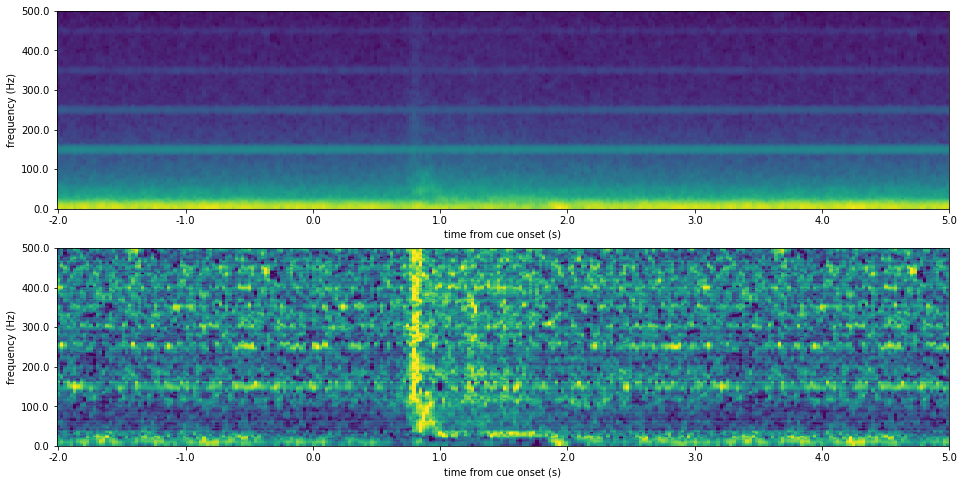

In [99]:
plt.figure(figsize=(16,8))

plt.subplot(2,1,1)
plt.imshow(tfdata, aspect='auto')
plt.yticks(np.linspace(0, rho*500, 6), np.linspace(0, 500, 6))
plt.xticks(np.linspace(0, len(tspec), 8), np.linspace(-2, 5, 8))
plt.ylim(0,rho*500)
plt.ylabel("frequency (Hz)")
plt.xlabel("time from cue onset (s)")

plt.subplot(2,1,2)
plt.imshow(shifted/np.reshape(np.max(shifted,1),(1000,1)), aspect='auto')
plt.yticks(np.linspace(0, rho*500, 6), np.linspace(0, 500, 6))
plt.xticks(np.linspace(0, len(tspec), 8), np.linspace(-2, 5, 8))
plt.ylim(0,rho*500)
plt.ylabel("frequency (Hz)")
plt.xlabel("time from cue onset (s)")

plt.show()
plt.close()

In [ ]:
tfcurve = np.mean(tfdata[rho*30:rho*80,:],0)
tfcurve_mu = np.mean(tfcurve[np.where(tspec<2)])
tfcurve_shift = tfcurve - tfcurve_mu
tfcurve_sig = np.std(tfcurve[np.where(tspec<2)])
thresh = 3*tfcurve_sig

datarise_item = general.group_consecutive(np.where(tfcurve_shift > thresh)[0], gap=1)
if len(datarise_item[0]) == 0:
    datarise.append([np.nan])
else:
    points = []
    for each in datarise_item:
        x0, y0 = tspec[each[0]], tfcurve_shift[each[0]]
        xm1, ym1 = tspec[each[0]-1], tfcurve_shift[each[0]-1]
        points.append(x0 - y0 * (x0-xm1)/(y0-ym1))

plt.figure(figsize=(10,5))
plt.plot(tspec, tfcurve-tfcurve_mu, linewidth=3)
plt.hlines(0,0,7)
plt.hlines(thresh, 0, 7, 'r')
plt.vlines(2, -2*thresh,6*thresh)
# plt.vlines(points[0], 5*thresh, 6*thresh, 'g', linewidth=3)
plt.show()
# plt.savefig("example1.eps")
plt.close()
print(points)

In [ ]:
# preview rawdata

bandname = ["delta", "theta", "alpha", "beta", "gamma", "low gamma", "high gamma", "lowpass", "highpass"]
targetname = "highpass"
ch_bp = eegFilter.butter_bandpass(channels[chidx,:], targetname, fs, order=5)
ch_bp_split = general.split_datawithmarker(ch_bp, cue_onset, (-2, 5), fs)

plt.figure(figsize=(15,np.size(cue_onset)))
for idx in range(np.size(cue_onset)):
    plt.subplot(np.size(cue_onset),1,idx+1)
    plt.plot(ch_bp_split[idx, :])
    plt.vlines(2*fs, np.min(ch_bp_split[idx, :]), np.max(ch_bp_split[idx, :]))
    plt.xticks([])
    plt.xlim([0, len(ch_bp_split[idx, :])])
# plt.savefig(os.path.join(resultdir, "bandpass_review", os.path.splitext(filename)[0], "channel %d-%s.png"%(chidx, targetname)))
plt.show()
plt.close()

In [77]:
def dwt_tf(eeg_data, fs, frange, baseroi):
    # wavelet parameters
    wtime = np.linspace(-1,1,fs)
    nConv = np.size(eeg_data, 1) + 2*fs
    fft_eeg = fft(eeg_data, nConv)
    
    tf = np.zeros((np.size(frange), np.size(eeg_data, 1)))
    for idx, F in enumerate(frange):
        s = 6 / (2 * np.pi * F)
        wavelet = np.exp(2*1j*np.pi*wtime*F) * np.exp(- wtime**2/(2*s**2))  # morlet wavelet
        fft_wavelet = fft(wavelet, nConv)
        
        conv_wave = ifft(fft_wavelet*fft_eeg, nConv)
        conv_wave = conv_wave[:, fs//2:-(fs+fs//2)]
        temppow = np.mean(np.abs(conv_wave)**2,0)
        temppow_cal = 10*np.log10(temppow / np.mean(temppow[int(baseroi[0]*fs):int(baseroi[1]*fs)]))
        
        tf[idx, :] = temppow_cal

    return tf

/usr/local/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


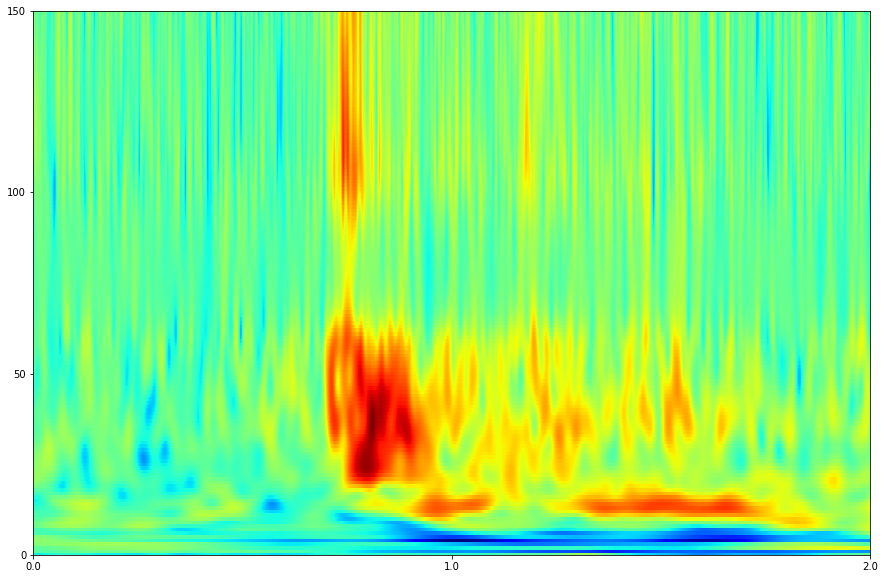

In [158]:
nstep = 500
tf_result = dwt_tf(ch_split, fs, np.linspace(0,500,nstep), (1.5, 2))
plt.figure(figsize=(15,10))
plt.imshow(tf_result[:, 100:-200], aspect='auto', cmap=plt.get_cmap("jet"))
plt.xticks(np.linspace(0, 14000, 8), np.linspace(-2,5,8))
plt.yticks(np.linspace(0,nstep,11), np.linspace(0,500,11, dtype='int'))
plt.ylim([0, 150])
plt.xlim([4000, 8000])
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


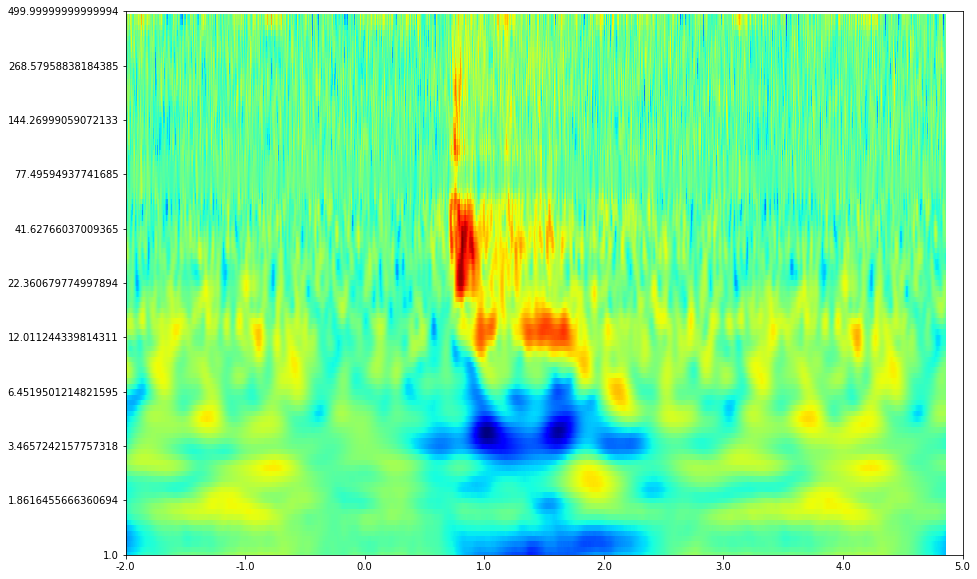

In [156]:
nstep = 100
tf_result = dwt_tf(ch_split, fs, np.logspace(0,np.log10(500),nstep), (1.5, 2))
plt.figure(figsize=(15,10))
plt.imshow(tf_result[:, 100:-200], aspect='auto', cmap=plt.get_cmap("jet"))
plt.xticks(np.linspace(0, 14000, 8), np.linspace(-2,5,8))
plt.yticks(np.linspace(0,nstep,11), np.logspace(0,np.log10(500),11))
plt.ylim([0, nstep])
plt.show()

![](screenshot.png)

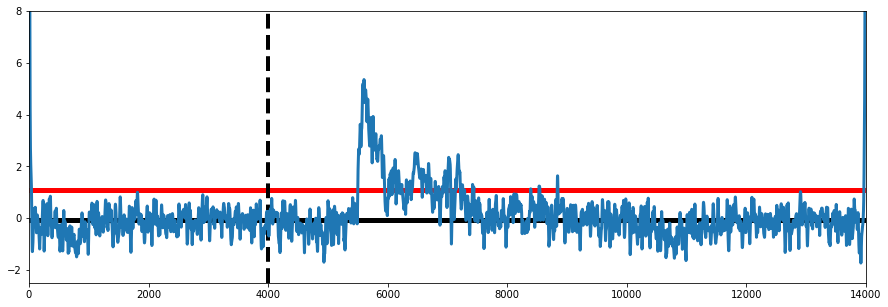

In [139]:
curve = np.mean(tf_result[30//5:150//5,:],0)

base_mu = np.mean(curve[1000:4000])
base_sig = np.std(curve[1000:4000])
threshn = 3

plt.figure(figsize=(15,5))
plt.plot(curve, linewidth=3)
plt.hlines(base_mu+threshn*base_sig, 0, 14000, 'r', linewidth=5)
plt.vlines(4000, -2.5, 8, linewidth=4, linestyle='--')
plt.hlines(base_mu, 0, 14000, 'k', linewidth=5)
plt.ylim([-2.5, 8])
plt.xlim([0, 14000])
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


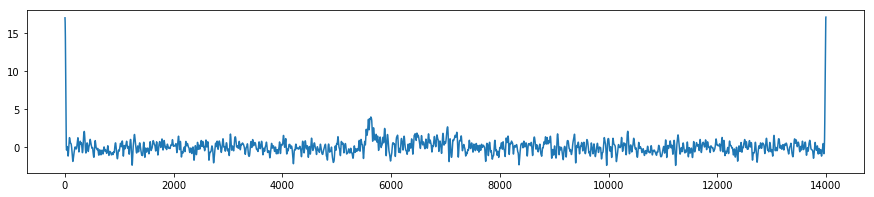

In [144]:
test_sample = ch_split
wtime = np.linspace(-1,1,fs)
nConv = np.size(test_sample,1) + fs*2

f = 90
s = 6 / (2 * np.pi * f)
wavelet = np.exp(2*1j*np.pi*wtime*f) * np.exp(- wtime**2/(2*s**2))  # morlet wavelet

fft_eeg = fft(test_sample, nConv)
fft_wavelet = fft(wavelet, nConv)

conv_wave = ifft(fft_wavelet*fft_eeg, nConv)
conv_wave = conv_wave[:, fs//2:-(fs+fs//2)]

# tf = np.mean(np.real(conv_wave), 0)

temppow = np.mean(np.abs(conv_wave)**2,0)
tf = 10*np.log10(temppow / np.mean(temppow[fs//2:2*fs]))

plt.figure(figsize=(15,3))
plt.plot(tf)
# plt.vlines(13800,0,6)
plt.show()

---
# Archive

In [ ]:
baseline_mu = np.mean(curve[:, np.where(t<2)[0]], 1)
baseline_std = np.std(curve[:, np.where(t<2)[0]], 1)

thresh = baseline_mu + 3*baseline_std

In [ ]:
latency = np.zeros(np.size(channels,0))
for idx in range(np.size(channels,0)):
    temp = t[np.where(curve[idx, :] > thresh[idx])]
    if len(temp) == 0:
        latency[idx] = np.nan
    else:
        latency[idx] = temp[0]
latency

In [ ]:
np.argsort(latency)

In [ ]:
plt.plot(t, curve[55,:])
plt.hlines(thresh[55], 0, 7)
plt.show()
plt.close()

In [ ]:
norm_curve = (curve - np.reshape(baseline_mu, (125,1))) / np.reshape(baseline_std, (125,1))

In [ ]:
plt.figure(figsize=(10,6))
plt.imshow(norm_curve, aspect='auto')
# plt.plot(norm_curve[6,:])
plt.show()

In [ ]:
np.size(p,-1)

In [ ]:
bandpower = np.mean(np.mean(p,0)[0:60, :], 0)
plt.plot(bandpower)
plt.show()

In [ ]:
bandpower = np.mean(np.mean(p,0)[60:160, :], 0)
plt.plot(bandpower)
plt.show()

In [ ]:
for i in range(len(cue_onset)):
    plt.plot(np.mean(p[1,:,:], 0))
    plt.show()

In [ ]:
plt.figure(figsize=(25,np.size(cue_onset)))
plt.subplot(np.size(cue_onset)+1,1,1)
bandpower = np.mean(np.mean(p,0)[100:200, :], 0)
plt.plot(bandpower,'r')

for idx in range(np.size(cue_onset)):
    plt.subplot(np.size(cue_onset)+1,1,idx+2)
    plt.plot(np.mean(p[idx, :, :], 0))
    plt.xticks([])
#     plt.xlim([0, len(ch_bp_split[idx, :])])

plt.show()

In [ ]:
?os.path.exists

---
# latency detection

In [ ]:
filename = "0903-1-5-rawdata.mat"
datadir = "../Data/"
resultdir = "../Result/"
tfdata = loadmat(os.path.join(resultdir, "tfERP", os.path.splitext(filename)[0], os.path.splitext(filename)[0]+"tf.mat"))["power_channels"]
tspec = loadmat(os.path.join(resultdir, "tfERP", os.path.splitext(filename)[0], os.path.splitext(filename)[0]+"tf.mat"))["tspec"][0,:] - 2

In [ ]:
plt.figure(figsize=(10,5))
plt.imshow(tfdata[1,np.logspace(0,np.log10(2500),200, dtype="int")-1,:], aspect='auto')
plt.yticks(np.linspace(1,200,10), np.logspace(0,np.log10(2500),10, dtype="int")/2)
plt.xticks(np.linspace(0, 280, 8), np.linspace(-2, 5, 8))
plt.ylabel("frequency (Hz) [in log]")
plt.xlabel("time (s)")
plt.show()

In [ ]:
tfdata[80,:,:]**2

In [ ]:
np.shape(np.reshape(np.max(tfdata[80,:,:],1),(1000,1)))

In [ ]:
plt.figure(figsize=(10,2))
shifted = tfdata[44,:,:]-np.reshape(np.min(tfdata[44,:,:],1),(1000,1))
plt.imshow(shifted/np.reshape(np.max(shifted,1),(1000,1)), aspect='auto')
# plt.yticks(np.linspace(0, 5*500, 11), np.linspace(0, 500, 11))
plt.xticks(np.linspace(0, 280, 8), np.linspace(-2, 5, 8))
# plt.ylim(0,100)
plt.ylabel("frequency (Hz)")
plt.xlabel("time (s)")
plt.show()

In [ ]:
plt.figure(figsize=(10,2))
shifted = tfdata[44,:,:]-np.reshape(np.min(tfdata[44,:,:],1),(1000,1))
plt.imshow(shifted/np.reshape(np.max(shifted,1),(1000,1)), aspect='auto')
# plt.yticks(np.linspace(0, 5*500, 11), np.linspace(0, 500, 11))
# plt.xticks(np.linspace(0, 280, 8), np.linspace(-2, 5, 8))
# plt.ylim(0,100)
plt.ylabel("frequency (Hz)")
plt.xlabel("time (s)")
plt.show()

In [ ]:
def group_consecutive(a, gap=1):
    ''' group consecutive numbers in an array
        modified from https://zhuanlan.zhihu.com/p/29558169'''
    return np.split(a, np.where(np.diff(a) > gap)[0] + 1)

In [ ]:
rho = 5

In [ ]:
cutoff = getBandRange("gamma")
n = 3

datarise = []
for chidx in range(np.size(tfdata, 0)):
    tfcurve = np.mean(tfdata[chidx,rho*cutoff[0]:rho*cutoff[1],:],0)
    tfcurve_mu = np.mean(tfcurve[np.where(tspec<0)])
    tfcurve_shift = tfcurve - tfcurve_mu
    tfcurve_sig = np.std(tfcurve[np.where(tspec<0)])
    thresh = n*tfcurve_sig
    
    datarise_item = group_consecutive(np.where(tfcurve_shift > thresh)[0], gap=5)
    if len(datarise_item[0]) == 0:
        datarise.append([np.nan])
    else:
        points = []
        for each in datarise_item:
            x0, y0 = tspec[each[0]], tfcurve_shift[each[0]]
            xm1, ym1 = tspec[each[0]-1], tfcurve_shift[each[0]-1]
            points.append(x0 - y0 * (x0-xm1)/(y0-ym1))
        datarise.append(points)


In [ ]:
latency = np.array([])
for idx, item in enumerate(datarise):
    point = np.nan
    for each in item:
        if each > 0:
            point = each
            break
    latency = np.append(latency, point)

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(range(125),np.sort(latency))

In [ ]:
group_consecutive(np.where(tfcurve_shift > thresh)[0], step=5)

In [ ]:
rho=2

In [ ]:
tfcurve = np.mean(tfdata[106,rho*30:rho*80,:],0)
tfcurve_mu = np.mean(tfcurve[np.where(tspec<2)])
tfcurve_shift = tfcurve - tfcurve_mu
tfcurve_sig = np.std(tfcurve[np.where(tspec<2)])
thresh = 3*tfcurve_sig

plt.figure(figsize=(10,5))
plt.plot(tspec, tfcurve-tfcurve_mu, linewidth=3)
plt.hlines(0,0,7)
plt.hlines(thresh, 0, 7, 'r')
plt.vlines(2, -2*thresh,6*thresh)
# plt.show()
plt.savefig("example1.eps")
plt.close()

In [ ]:
np.where(np.mean(tfdata[1,rho*30:rho*150,:],0) > )